In [2]:
import pickle
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# data
table = 'regressor_5sgm.npy'
path = '/data01/homes/dipiano/E4/irf_random/crab/'
dataset = join(path, table)

# dataset 
if '.pickle' in table:
    with open(dataset,'rb') as f: ds = pickle.load(f)
    infotable = join(path, table.replace('.pickle', '.dat'))
elif '.npy' in table:
    ds = np.load(dataset, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
    infotable = join(path, table.replace('.npy', '.dat'))


print(f"Maps: {ds.keys()}")
print(f"DS dataset size: {len(ds['DS'])}")

Maps: dict_keys(['DS', 'LABELS'])
DS dataset size: 10000


In [3]:
from astroai.tools.utils import split_regression_dataset

binning = 200
train_data, train_labels, test_data, test_labels = split_regression_dataset(ds, split=80, reshape=True, binning=binning)

print(f"Train dataset: {len(train_data)}, {train_data.shape}")
print(f"Train labels: {len(train_labels)}, {train_labels.shape}")
print(f"\nTest dataset: {len(test_data)}, {test_data.shape}")
print(f"Test labels: {len(test_labels)}, {test_labels.shape}")

(8000, 200, 200) (8000, 2)
Train dataset: 8000, (8000, 200, 200, 1)
Train labels: 8000, (8000, 2)

Test dataset: 2000, (2000, 200, 200, 1)
Test labels: 2000, (2000, 2)


In [4]:
import numpy as np
from astroai.tools.utils import plot_heatmap, set_wcs

# get random seed
idx = np.random.choice(range(len(train_data)))
# find seed to get the original heatmap
seed = idx + 1

# get simulation data
infodata = pd.read_csv(infotable, sep=' ', header=0).sort_values(by=['seed'])
row = infodata[infodata['seed']==seed]
row

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
18454,crab_03455,3455,0,100,100,63.679615,32.703503,62.701508,32.039354,1.059963,North_z20_N_50h_LST,2.5,6.716373


# Load model and weights

In [24]:
import tensorflow as tf

savename = 'regressor_5sgm_filter2_2convs' 
model = tf.keras.models.load_model(f'../models/cnn_regressor/{savename}.keras')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 197, 197, 2)       34        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 2)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 4)         36        
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 4)         68        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 4)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 48, 48, 4)         0

In [25]:
%time
predictions = model.predict(test_data) * binning
predictions[idx], test_labels[idx] * binning

CPU times: user 13 µs, sys: 6 µs, total: 19 µs
Wall time: 37.2 µs
63/63 [==============================] - 1s 7ms/step


(array([71.771416, 90.20944 ], dtype=float32), array([24.8709436, 90.4061186]))

In [26]:
from astroai.tools.utils import *

binning = 200
pixelsize = (2 * row['fov'].values[0]) / binning
point_ref = (binning / 2) + (pixelsize / 2)
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)

# TRUE
true_sky = SkyCoord(ra=row['source_ra'].values[0], dec=row['source_dec'].values[0], unit='deg', frame='icrs')
x, y = w.world_to_pixel(true_sky) 
true_sky = true_sky.ra.deg, true_sky.dec.deg
true_pix = x, y

# LABEL
label_pix = train_labels[idx][0] * binning, train_labels[idx][1] * binning
sky = w.pixel_to_world(label_pix[0], label_pix[1])
label_sky = sky.ra.deg, sky.dec.deg

print(f"TRUE TO PIX: {true_pix}")
print(f"LABEL: {label_pix}")
print(f"TRUE: {true_sky} ")
print(f"LABEL SKY: {label_sky}")

'PREDICTION: (293.72090247862394, -63.437713007205275) TRUE: (291.6853867382947, -63.46602306541158)'

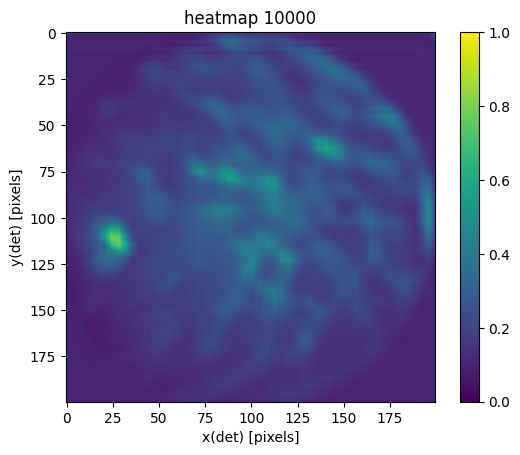

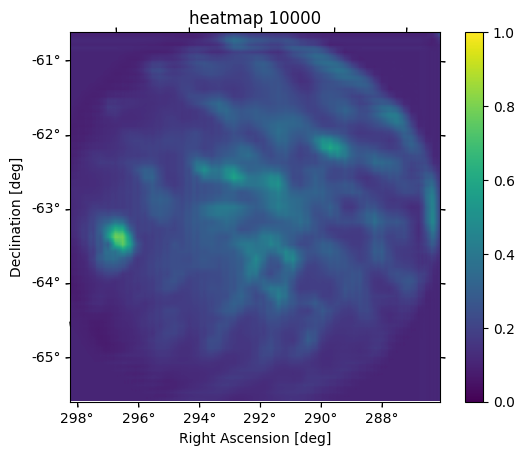

In [27]:
import astropy.units as u
from matplotlib.lines import Line2D

radius_deg = 0.2
radius_pix = radius_deg/0.025
figsize = (6, 6)

# PLOT
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121), fig.add_subplot(122, projection=w)

# PIX
ax[0].imshow(train_data[idx], vmin=0, vmax=1)
ax[0].add_patch(plt.Circle((true_pix), radius=radius_pix, edgecolor='r', facecolor='none'))
ax[0].add_patch(plt.Circle((label_pix), radius=radius_pix, edgecolor='k', facecolor='none', ls='-.'))
ax[0].set_ylabel('y [pixels]')
ax[0].set_xlabel('x [pixels]')

# SKY
ax[1].imshow(train_data[idx], vmin=0, vmax=1)
ax[1].scatter(true_sky[0], true_sky[1], transform=ax[1].get_transform('icrs'), s=300,
               edgecolor='r', facecolor='none')
ax[1].scatter(label_sky[0], label_sky[1], transform=ax[1].get_transform('icrs'), s=300,
               edgecolor='k', facecolor='none', ls='-.')
ax[1].set_ylabel('y [pixels]')
ax[1].set_xlabel('x [pixels]')

# LEGENDS
custom_lines = [Line2D([0], [0], color='r', lw=1, ls='-'),
                Line2D([0], [0], color='k', lw=1, ls='-.')]
ax[0].legend(custom_lines, ['true', 'label'])
ax[1].legend(custom_lines, ['true', 'label'])

plt.show()

# Plot loss

In [29]:
loss = model.evaluate(test_data, test_labels, verbose=2)

63/63 - 1s - loss: 0.0468 - accuracy: 0.9465 - 604ms/epoch - 10ms/step


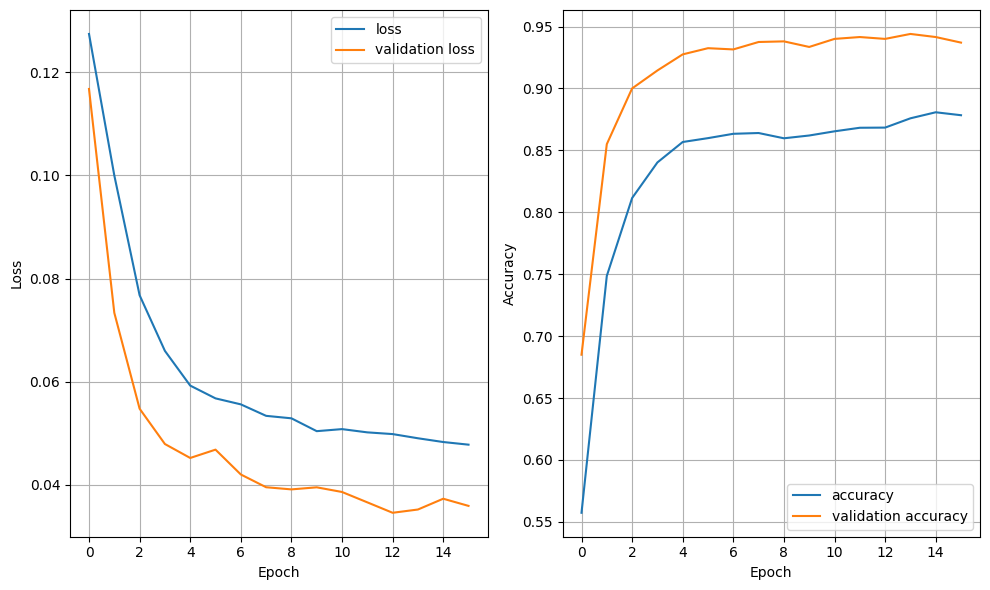

In [30]:
import matplotlib.pyplot as plt

history = np.load(f'/data01/homes/dipiano/astroAI/astroai/models/cnn_regressor/{savename}_history.npy', 
                  allow_pickle='TRUE').item()


fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].plot(history['loss'], label='loss')
ax[0].plot(history['val_loss'], label = 'validation loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
#ax.set_ylim([0.2,0.65])
ax[0].grid()
ax[0].legend(loc=0)

ax[1].plot(history['accuracy'], label='accuracy')
ax[1].plot(history['val_accuracy'], label = 'validation accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
#ax.set_ylim([0.2,0.65])
ax[1].grid()
ax[1].legend(loc=0)

plt.tight_layout()
plt.show()

# Get separation error

In [31]:
from astroai.tools.utils import *
from astropy.coordinates import SkyCoord

# get true coordinates in SkyCoord
true = SkyCoord(ra=row['source_ra'].values[0], dec=row['source_dec'].values[0], unit='deg', frame='icrs')

# get errors
err = true.separation(sky)

print(f"TRUE: ({true.ra.deg}, {true.dec.deg})\n")
print(f"PREDICTION: ({sky.ra.deg}, {sky.dec.deg})\n")
print(f"ERROR: {err.deg}")

TRUE: (291.6853867382947, -63.46602306541158)

PREDICTION: (293.72090247862394, -63.437713007205275)

ERROR: 0.9101746283894998


# Get DS separation error

In [32]:
err = []
s = len(train_data)
for pred, label in zip(predictions, test_labels):
    s += 1 
    row = infodata[infodata['seed']==s]
    # WCS coordinates
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
                point_ref=point_ref, pixelsize=pixelsize)
    # simulated coordinates
    true_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
    true_pix = {'x': label[0], 'y': label[1]}
    # prediction coordinates
    sky = w.pixel_to_world(pred[0], pred[1])
    found_deg = {'ra': sky.ra.deg, 'dec': sky.dec.deg}
    # find separation in data
    true_sky = SkyCoord(ra=true_deg['ra'], dec=true_deg['dec'], unit='deg', frame='icrs')
    found_sky = SkyCoord(ra=found_deg['ra'], dec=found_deg['dec'], unit='deg', frame='icrs')
    err.append(true_sky.separation(found_sky))

err_noisy = [e.degree for e in err]
len(err_noisy)

2000

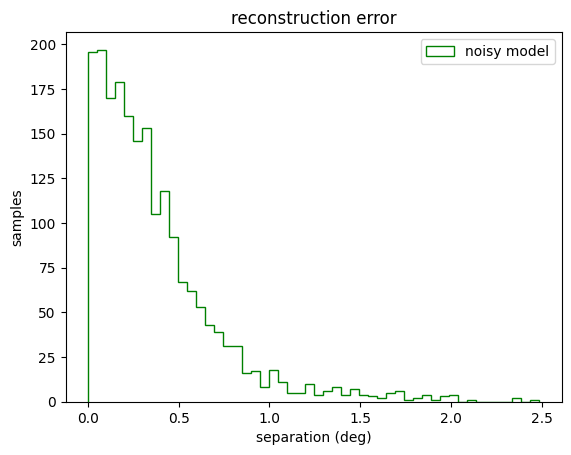

In [33]:
ax = plt.subplot()

# cumulative counts hist
data = err_noisy
ax.set_title('reconstruction error')
ax.hist(data, 50, density=False, histtype='step', color='g', label=['noisy model'])
ax.set_ylabel('samples')
ax.set_xlabel('separation (deg)')
ax.legend()

# Compare with cleaned model

In [34]:
# dataset 
if 'CLEAN' not in mapsname:
    mapsname = mapsname.replace('.npy', '_CLEAN.npy')
ds = np.load(mapsname, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]

# split data
train_data, train_labels, test_data, test_labels = split_regression_dataset(ds, split=80, reshape=True, 
                                                                            binning=binning)
# load model
if 'CLEAN' not in savename:
    savename = savename + '_CLEAN'
model = tf.keras.models.load_model(f'../models/cnn_regressor/{savename}.keras')
model.summary()

# predictions
predictions = model.predict(test_data) * binning
predictions[idx], test_labels[idx] * binning

FileNotFoundError: [Errno 2] No such file or directory: '/data01/homes/dipiano/E4/irf_random/crab/regressor_100s_5sgm_10000sz_200x200_YESnorm_NOstretch_CLEAN.npy'

In [ ]:
err = []
s = len(train_data)
for pred, label in zip(predictions, test_labels):
    s += 1 
    row = infodata[infodata['seed']==s]
    # WCS coordinates
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
                point_ref=point_ref, pixelsize=pixelsize)
    # simulated coordinates
    true_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
    true_pix = {'x': label[0], 'y': label[1]}
    # prediction coordinates
    sky = w.pixel_to_world(pred[0], pred[1])
    found_deg = {'ra': sky.ra.deg, 'dec': sky.dec.deg}
    # find separation in data
    true_sky = SkyCoord(ra=true_deg['ra'], dec=true_deg['dec'], unit='deg', frame='icrs')
    found_sky = SkyCoord(ra=found_deg['ra'], dec=found_deg['dec'], unit='deg', frame='icrs')
    err.append(true_sky.separation(found_sky))
    
err_clean = [e.degree for e in err]
len(err_clean)

In [ ]:
ax = plt.subplot()

# cumulative counts hist
data = err_clean
ax.set_title('reconstruction error')
ax.hist(data, 50, density=False, histtype='step', color='g', label=['cleaned model'])
ax.set_ylabel('samples')
ax.set_xlabel('on-sky separation (deg)')
ax.legend()

# Comparison hist

Model yx is the one with better improvement.

In [ ]:
data = (err_noisy, err_clean)

ax = plt.subplot()
colors = ['red', 'blue'] 

# cumulative counts hist
ax.set_title('reconstruction error')
ax.hist(data, 50, density=False, histtype='step', color=colors, label=['noisy', 'cleaned'])
ax.set_ylabel('samples')
ax.set_xlabel('on-sky separation (deg)')
#ax.set_xscale('log')
ax.legend()

# Gammapy comparison

In [ ]:
gammafile = f'{root}/map_200x200_randomEXP_gp/randomIRF.txt'
gammadata = pd.read_csv(gammafile, sep=' ', header=0).sort_values(by=['seed'])
gammadata.head()

In [ ]:
err = []
seeds = gammadata['seed']
for i, seed in enumerate(seeds):
    row = infodata[infodata['seed']==seed]
    grow = gammadata[gammadata['seed']==seed]
    # WCS coordinates
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
                point_ref=point_ref, pixelsize=pixelsize)
    # simulated coordinates
    true_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
    # found coordinates
    found_deg = {'ra': grow['loc_ra'].values[0], 'dec': grow['loc_dec'].values[0]}
    # find separation in data
    true_sky = SkyCoord(ra=true_deg['ra'], dec=true_deg['dec'], unit='deg', frame='icrs')
    found_sky = SkyCoord(ra=found_deg['ra'], dec=found_deg['dec'], unit='deg', frame='icrs')
    err.append(true_sky.separation(found_sky))
    
err_gamma = [e.degree for e in err]
len(err_gamma)

In [ ]:
data = (err_noisy, err_clean, err_gamma)

ax = plt.subplot()
colors = ['red', 'blue', 'green'] 

# cumulative counts hist
ax.set_title('reconstruction error')
ax.hist(data, 50, density=False, histtype='step', color=colors, label=['noisy', 'cleaned', 'gamma'])
ax.set_ylabel('samples')
ax.set_xlabel('on-sky separation (deg)')
#ax.set_xscale('log')
ax.legend()